In [193]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [194]:
START_YEAR = 1880
END_YEAR = 2023
BASELINE_START_YEAR = 1951
BASELINE_END_YEAR = 1980

year_range_v4 = range(START_YEAR, END_YEAR+2)
year_range_v5 = range(START_YEAR, END_YEAR+1)

In [195]:
def area_weight(ds, yearly=False):
    weights = np.cos(np.deg2rad(ds['lat']))
    weights.name = 'weights'
    ds_weighted = ds.temp.weighted(weights)
    ds_weighted_mean = ds_weighted.mean(('lon', 'lat'))
    if yearly:
        return ds_weighted_mean
    else:
        ds_yearly = ds_weighted_mean.resample(time='Y').mean(dim='time')
        return ds_yearly

In [196]:
v5_path = "/Users/aherron1/Documents/Projects/GISTEMP/GISTEMP_rewrite/post-processing/gistemp_result_baseline.nc"
ds_v5 = xr.open_dataset(v5_path)
v5_timeseries = area_weight(ds_v5, yearly=False)

In [197]:
ds_v5

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 180, time: 1728)
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-12-01
    month    (time) int64 ...
Data variables:
    temp     (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan

In [198]:
v4_path = "/Users/aherron1/Documents/Projects/GISTEMP/GISTEMP_rewrite/post-processing/gistemp1200_GHCNv4_ERSSTv5.nc"
ds_v4 = xr.open_dataset(v4_path)
ds_v4 = ds_v4.rename_vars({"tempanomaly": "temp"})
v4_timeseries = area_weight(ds_v4)

v5_path = "/Users/aherron1/Documents/Projects/GISTEMP/GISTEMP_rewrite/post-processing/gistemp_result_baseline.nc"
ds_v5 = xr.open_dataset(v5_path)
v5_timeseries = area_weight(ds_v5)

v5_path_1 = "/Users/aherron1/Documents/Projects/GISTEMP/GISTEMP_rewrite/post-processing/gistemp_result_step1.nc"
ds_v5_1 = xr.open_dataset(v5_path_1)
v5_timeseries_1 = area_weight(ds_v5_1)

v5_path_13 = "/Users/aherron1/Documents/Projects/GISTEMP/GISTEMP_rewrite/post-processing/gistemp_result_step13.nc"
ds_v5_13 = xr.open_dataset(v5_path_13)
v5_timeseries_13 = area_weight(ds_v5_13)

# Regular Averaging (v4 vs. v5)

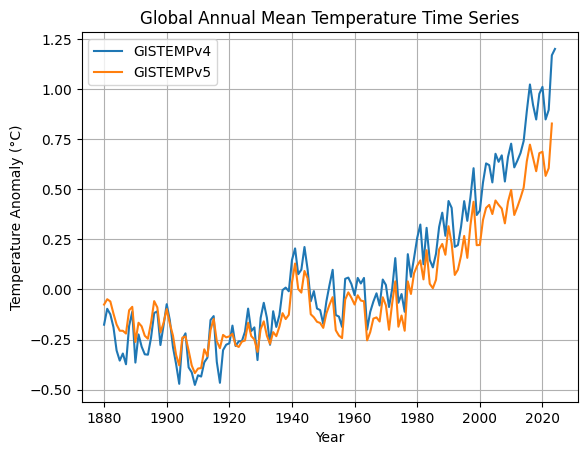

In [199]:
# Plot regular timeseries
plt.plot(year_range_v4, v4_timeseries, label='GISTEMPv4')
plt.plot(year_range_v5, v5_timeseries_13, label='GISTEMPv5')

# Customize the plot (optional)
plt.title('Global Annual Mean Temperature Time Series')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid()
plt.legend()
plt.show()

# GISTEMP-Specific Averaging Algorithm

https://data.giss.nasa.gov/gistemp/station_data_v4_globe/seas_ann_means.html

In [201]:
def gistemp_averaging(ds):

    # 0. Drop month coordinate (included in time)
    #ds = ds.drop_vars('month')

    # Custom time coordinate to ensure that Dec-Nov year is used
    # (As opposed to Jan-Dec year), for winter including Dec/Jan/Feb
    custom_time = xr.cftime_range(start='1880-01', periods=len(ds.time), freq='MS')

    # Assign the custom time coordinate to the dataset
    ds = ds.assign_coords(time=custom_time)

    # 1. Calculate monthly averages for all data
    mon_avg = ds.groupby('time.month').mean(dim='time')

    # 2. Compute seasonal averages for all data 
    seas_avg = ds.groupby('time.season').mean(dim='time')

    # 3. Compute annual averages for all data
    ann_avg = seas_avg.mean(dim=['season'])

    # 4. Calculate monthly anomaly series
    # NOTE: THIS IS NEVER USED!
    dmon_data_array = ds['temp'] - mon_avg['temp']
    dmon_data_array = dmon_data_array.drop_vars('month')
    dmon = xr.Dataset({'temp': dmon_data_array})

    # 5. Calculate seasonal anomalies from monthly anomalies

    #################################################################################
    ### Seasonal averages must be calculated using at least 2 monthly data points ###
    #################################################################################

    # Group original dataset by year
    yearly_data = ds.groupby('time.year')

    # Initial list for seasonal averages
    valid_seasonal_averages = []

    # Loop through each year
    for year, ds_year in yearly_data:

        # Group each yearly dataset by season
        seasonal_data_year = ds_year.groupby('time.season')

        # Calculate seasonal averages for each year
        seasonal_averages_year = seasonal_data_year.mean(dim='time')

        # Count number of NaN values contributing to each seasonal average
        nan_counts_year = seasonal_data_year.apply(lambda x: x.isnull().sum(dim='time'))

        # Ensure that NaN count for seasonal average for each year does not exceed 1
        valid_seasonal_averages_year = seasonal_averages_year.where(nan_counts_year <= 1)

        # Add time coordinate as a coordinate
        valid_seasonal_averages_year = valid_seasonal_averages_year.assign_coords(time=ds_year['time'].values[0])

        # Add each seasonal average to list
        valid_seasonal_averages.append(valid_seasonal_averages_year)

    # Concatenate list of seasonal averages into complete dataset
    dseas = xr.concat(valid_seasonal_averages, dim='year')

    # 6. Calculate annual anomalies from seasonal

    ####################################################
    ### Need >= 3 seasonal values for annual average ###
    ####################################################

    # Calculate the count of non-missing seasonal anomalies for each year
    seasonal_anomalies_count = dseas.groupby('time.year').count(dim='season')

    # Create a mask indicating which years have at least 3 out of 4 seasons present
    valid_years_mask = (seasonal_anomalies_count >= 3)

    # Calculate the annual anomalies only for years with at least 3 out of 4 seasons present
    dann = dseas.mean(dim='season').where(valid_years_mask)

    # Exclude December of the current year (as it belongs to the next year's winter season)
    dann = dann.shift(year=-1)

    # 7.a. Calculate absolute seasonal means
    # (step 2 + step 5)

    seas = dseas + seas_avg

    # 7.b. Calculate absolute seasonal means
    # (step 3 + step 6)

    ann = dann + ann_avg

    # Shift by 1 year
    ann = ann.shift(year=1)
    return ann

# GISTEMP Averaging (v4 vs. v5)

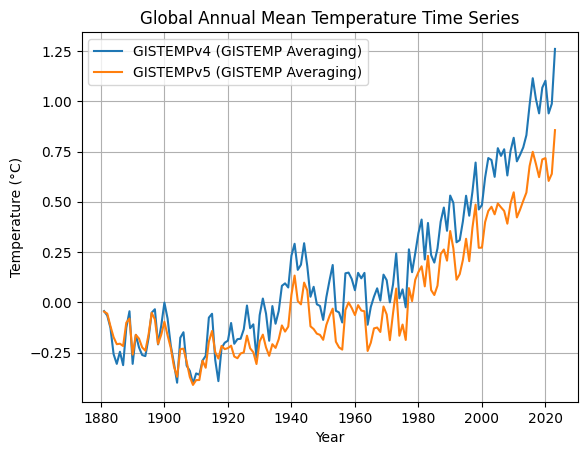

In [202]:
# Calculate gistemp averages (account for area weighting as well)
ds_gistemp_v4 = gistemp_averaging(ds_v4)
ds_gistemp_v4_timeseries = area_weight(ds_gistemp_v4, yearly=True)
ds_gistemp_v5 = gistemp_averaging(ds_v5)
ds_gistemp_v5_timeseries = area_weight(ds_gistemp_v5, yearly=True)

# Plot
plt.plot(year_range_v4, ds_gistemp_v4_timeseries, label='GISTEMPv4 (GISTEMP Averaging)')
plt.plot(year_range_v5, ds_gistemp_v5_timeseries, label='GISTEMPv5 (GISTEMP Averaging)')
plt.title('Global Annual Mean Temperature Time Series')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.legend()
plt.show()

# Spatial Plotting

In [203]:
def spatial_plot(ds, time_index):

    # The most recent time slice
    most_recent_date = ds.time[time_index]

    # Extract the data for the most recent date
    data_most_recent = ds.sel(time=most_recent_date)

    # Plot the data
    plt.figure(figsize=(10, 5))
    data_most_recent.temp.plot()

    # Add title and labels
    plt.title('Temperature on {}'.format(most_recent_date.values))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

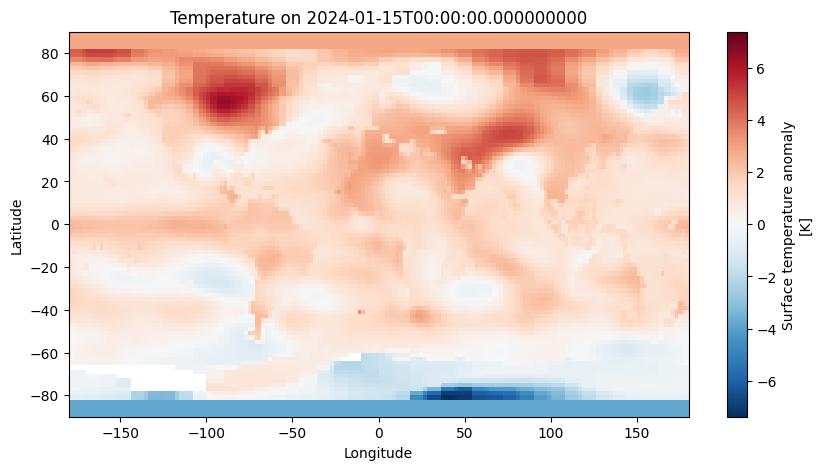

In [204]:
spatial_plot(ds_v4, -1)

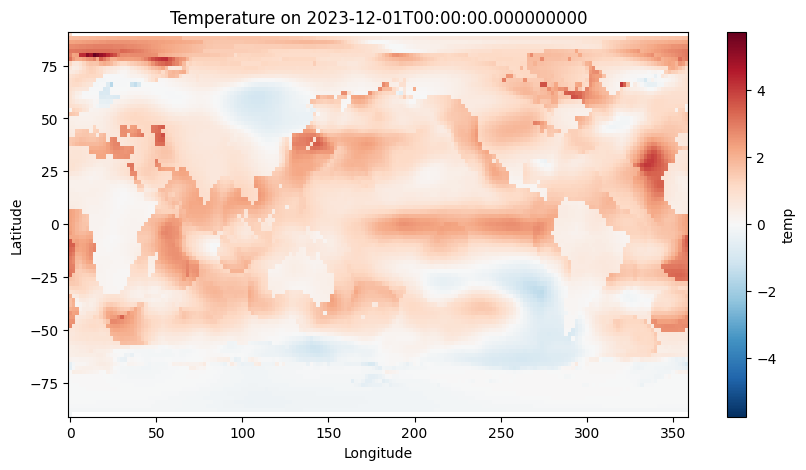

In [205]:
spatial_plot(ds_v5, -1)

In [189]:
x = 5 + np.nan
x

nan